# Project: New York Taxi Fare Prediction

# Problem Statement
The New York City Taxi Fare prediction challenge is a supervised regression machine learning task. Given pickup and dropoff locations, the pickup timestamp, and the passenger count and other features the objective is to predict the fare of the taxi ride. Like most Kaggle competitions, this problem isn’t 100% reflective of those in industry, but it does present a realistic dataset and task on which we can apply our machine learning skills.

To execute the cell use Shift +Enter

To see parameters in any models or function use Shift + Tab

# Dataset Information

# ML Problem Foundation
This problem is Supervised Regression. The main objective is to predict fare_amount given the location coordinates(latitude and longitude), distance and other related features

# Performance metrics

Root Mean Squared error will be used as Performance metrics rather than mean absolute error.The main reason is that 
taking the square root of the average squared errors has some interesting implications for RMSE. 
Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. 
This means the RMSE should be more useful when large errors are particularly undesirable.

RMSE does not necessarily increase with the variance of the errors. 
RMSE increases with the variance of the frequency distribution of error magnitudes.

<b>Importing Dataset</b>

In [1]:
#importing Datasets
import pandas as pd
train_data = pd.read_csv('train.csv',nrows=600000)

In [2]:
#Overview of data
print("Number of Instances and feature in training data are ",train_data.shape)
train_data.head()

Number of Instances and feature in training data are  (600000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
train_data.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [5]:
#Checking for missing values
train_data.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    8
dropoff_latitude     8
passenger_count      0
dtype: int64

There are some missing values in drop_off longitude and drop_off latitude

In [6]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,600000.000000,600000.000000,600000.000000,599992.000000,599992.000000,600000.00000
mean,11.345247,-72.527156,39.922140,-72.522891,39.913588,1.68374
std,9.863018,12.413418,7.816577,11.592995,8.307124,1.30736
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.00000
25%,6.000000,-73.992037,40.734962,-73.991392,40.734054,1.00000
50%,8.500000,-73.981781,40.752707,-73.980142,40.753149,1.00000
75%,12.500000,-73.967096,40.767108,-73.963623,40.768127,2.00000
max,500.000000,2140.601160,1703.092772,40.851027,405.650000,6.00000


#Observations

1.Fare_amount ranges from (-44.9, 500), so negative values should be removed.

2.There are some some values in location coordinates(latitude and longitude) that are out of range.

3.In passanger_count there is zero count which is not fair, weneed to handle these values.

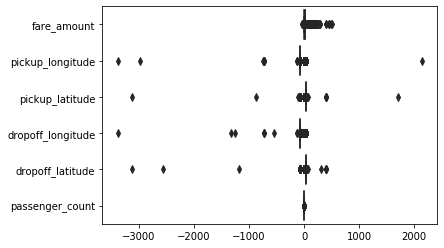

In [8]:
#Visualising all features to detect outliers in dataset
import seaborn as sns
ax = sns.boxplot(data=train_data, orient="h",color=".25")
ax

Except passenger_count, all other features have lots of outlier. We will remove outliers later.

# Visualization of location Coordinates
It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates Latitude range is  from 40.568973 to 41.709555 and Longitude range is from -74.263242 to -72.986532 so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York. 

In [9]:
import  folium  # read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html
#copy train_data to data
data = train_data.copy()

# Plotting pickoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
pickupoutliers=data.loc[(data.pickup_latitude<=40.568)|(data.pickup_longitude<=-74.263)|\
                    (data.pickup_latitude>=41.7095)|(data.pickup_longitude>=-72.986)
                   ]
print('The number of pickup outliers is',len(pickupoutliers))

# creating a map with the a base location
map_osm=folium.Map(location=[40.734695, -73.990372])

#Visualising first 10000 pickup Outliers out of range
sample_locations = pickupoutliers.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm


The number of pickup outliers is 12026


We observed that there are some pickup near the oceans and out of the New York City

In [11]:
# Plotting dropoff cordinates which are outside the bounding box of New-York
# we will collect all the points outside the bounding box of newyork city to outlier_locations
dropoffoutliers=data.loc[(data.dropoff_latitude<=40.568)|(data.dropoff_longitude<=-74.263)|\
                    (data.dropoff_latitude>=41.7095)|(data.dropoff_longitude>=-72.986)
                   ]
print('The number of dropoff outliers is',len(dropoffoutliers))

# creating a map with the a base location
map_osm=folium.Map(location=[40.734695, -73.990372])

#Visualsing first 10000 drop coordinates 
sample_locations = dropoffoutliers.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm   

The number of dropoff outliers is 12091


We observed that there are some drops near the oceans and out of the New York City


# Further Exploration

In [12]:
#Datatype Conversion
import pandas as pd
data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'])   

In [13]:
#Creating new columns based on datetime as days, hour ,day of week ,month ,year that greatly impacts the fare_amount
all_data = [data]
for i in all_data:
    i['Year'] = i['pickup_datetime'].dt.year
    i['Month'] = i['pickup_datetime'].dt.month
    i['Date'] = i['pickup_datetime'].dt.day
    i['Day of Week'] = i['pickup_datetime'].dt.dayofweek
    i['Hour'] = i['pickup_datetime'].dt.hour

In [14]:
data.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],
      dtype='object')

<b>Histogram of all  the features</b>

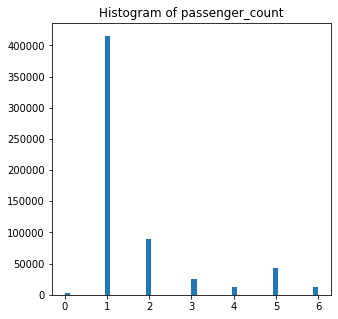

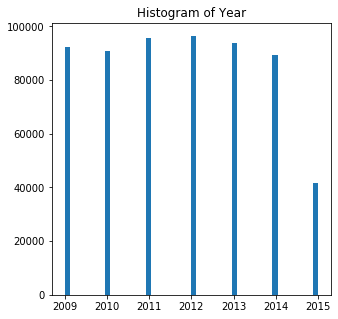

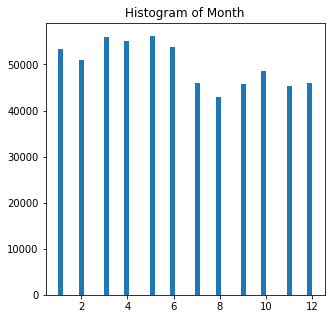

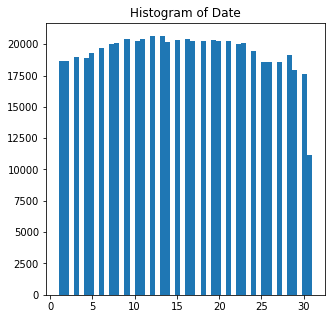

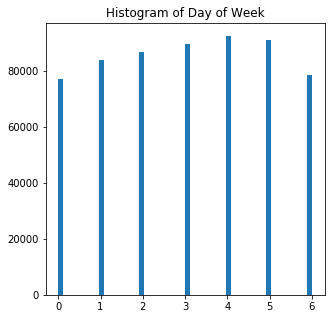

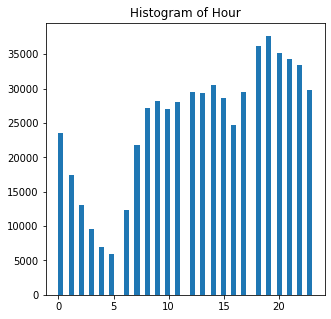

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
columns = ['passenger_count', 'Year', 'Month', 'Date', 'Day of Week', 'Hour']
n_bins = 50 # can decrease to get a wider bin (or vice versa)

for column_name in columns:
    ax=plt.subplots(figsize=(5,5))
    # get data by column_name and display a histogram
    ax = plt.hist(data[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

<b>ScatterPlot  of all features showing how each feature is related with respect to fare_amount</b>

In [16]:
my_list = ['passenger_count', 'Year', 'Month', 'Date', 'Day of Week', 'Hour']

def ScatterPlot(data,column):
    for column_name in my_list:
        plt.figure(figsize=(7,5))
        plt.scatter(data[column_name],data['fare_amount'])
        title="Scatter plot of fare with " + column_name
        plt.title(title, fontsize=12)
        plt.xlabel(column_name)
        plt.ylabel("Fare")
        plt.show()

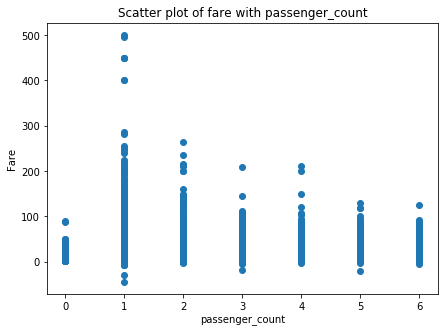

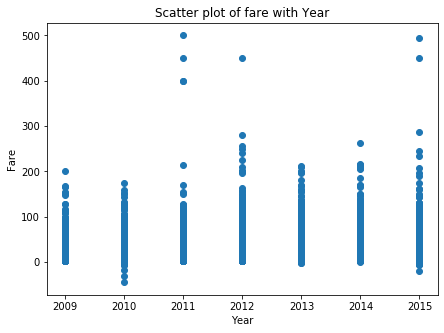

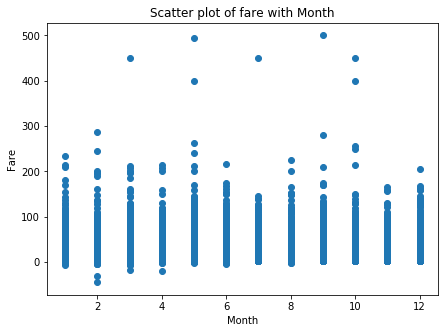

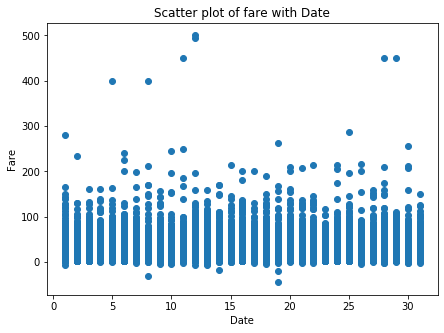

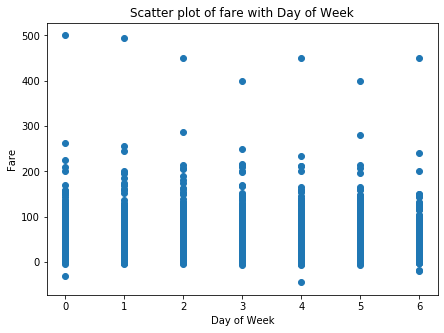

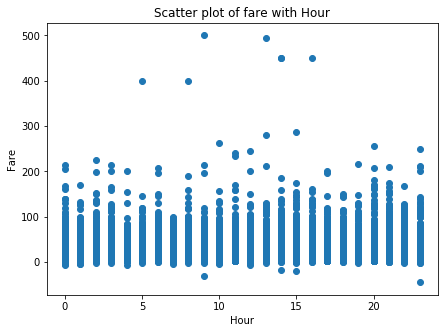

In [17]:
ScatterPlot(data,my_list)

<b>Next we will remove the outliers based on observed data</b> and  perform <b>modelling</b>